# Project: Adversarial BayesFlow

In [3]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import tensorflow_probability as tfp

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.diagnostics import true_vs_estimated
from bayesflow.exceptions import ConfigurationError

from bayesflow.applications.priors import GaussianPrior, TPrior
from bayesflow.applications.simulators import GaussianSimulator, MultivariateTSimulator

# (1) Define minimalistic BayesFlow
**Task:** Learn means of a 5-variate Gaussian with unit variance.

In [4]:
D = 5

#########

prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=D*2,  # one mean and variance per dim
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

In [5]:
trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      learning_rate=0.0001,
                      checkpoint_path='export_ckpt/'
                     )

Networks loaded from export_ckpt/ckpt-200


# (2) Converge BayesFlow network

In [ ]:
losses = trainer.train_rounds(epochs=20, rounds=5, sim_per_round=20000, batch_size=1024, n_obs=100)

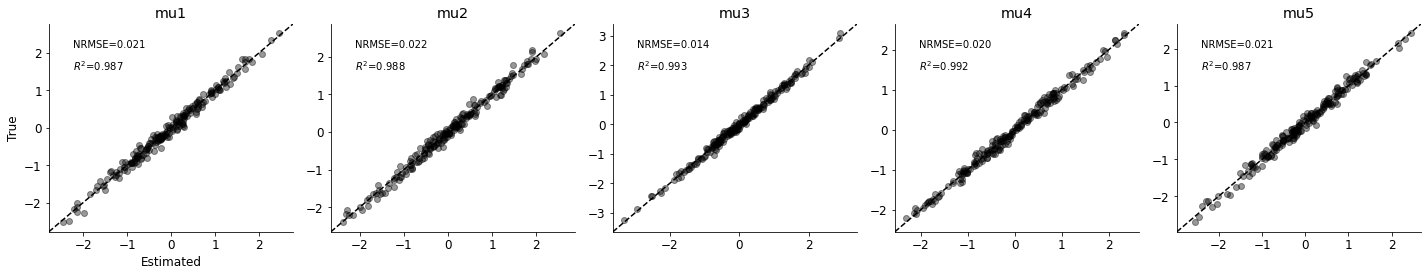

In [6]:
# Validate (quick and dirty)
p, x = trainer._forward_inference(200, 100)
param_samples = trainer.network.sample(x, n_samples=200)
param_means = param_samples.mean(axis=0)
true_vs_estimated(p, param_means, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))

In [46]:
theta, x = trainer._forward_inference(200, 100)
param_samples = trainer.network.sample(x, n_samples=200)
param_means = param_samples.mean(axis=0)

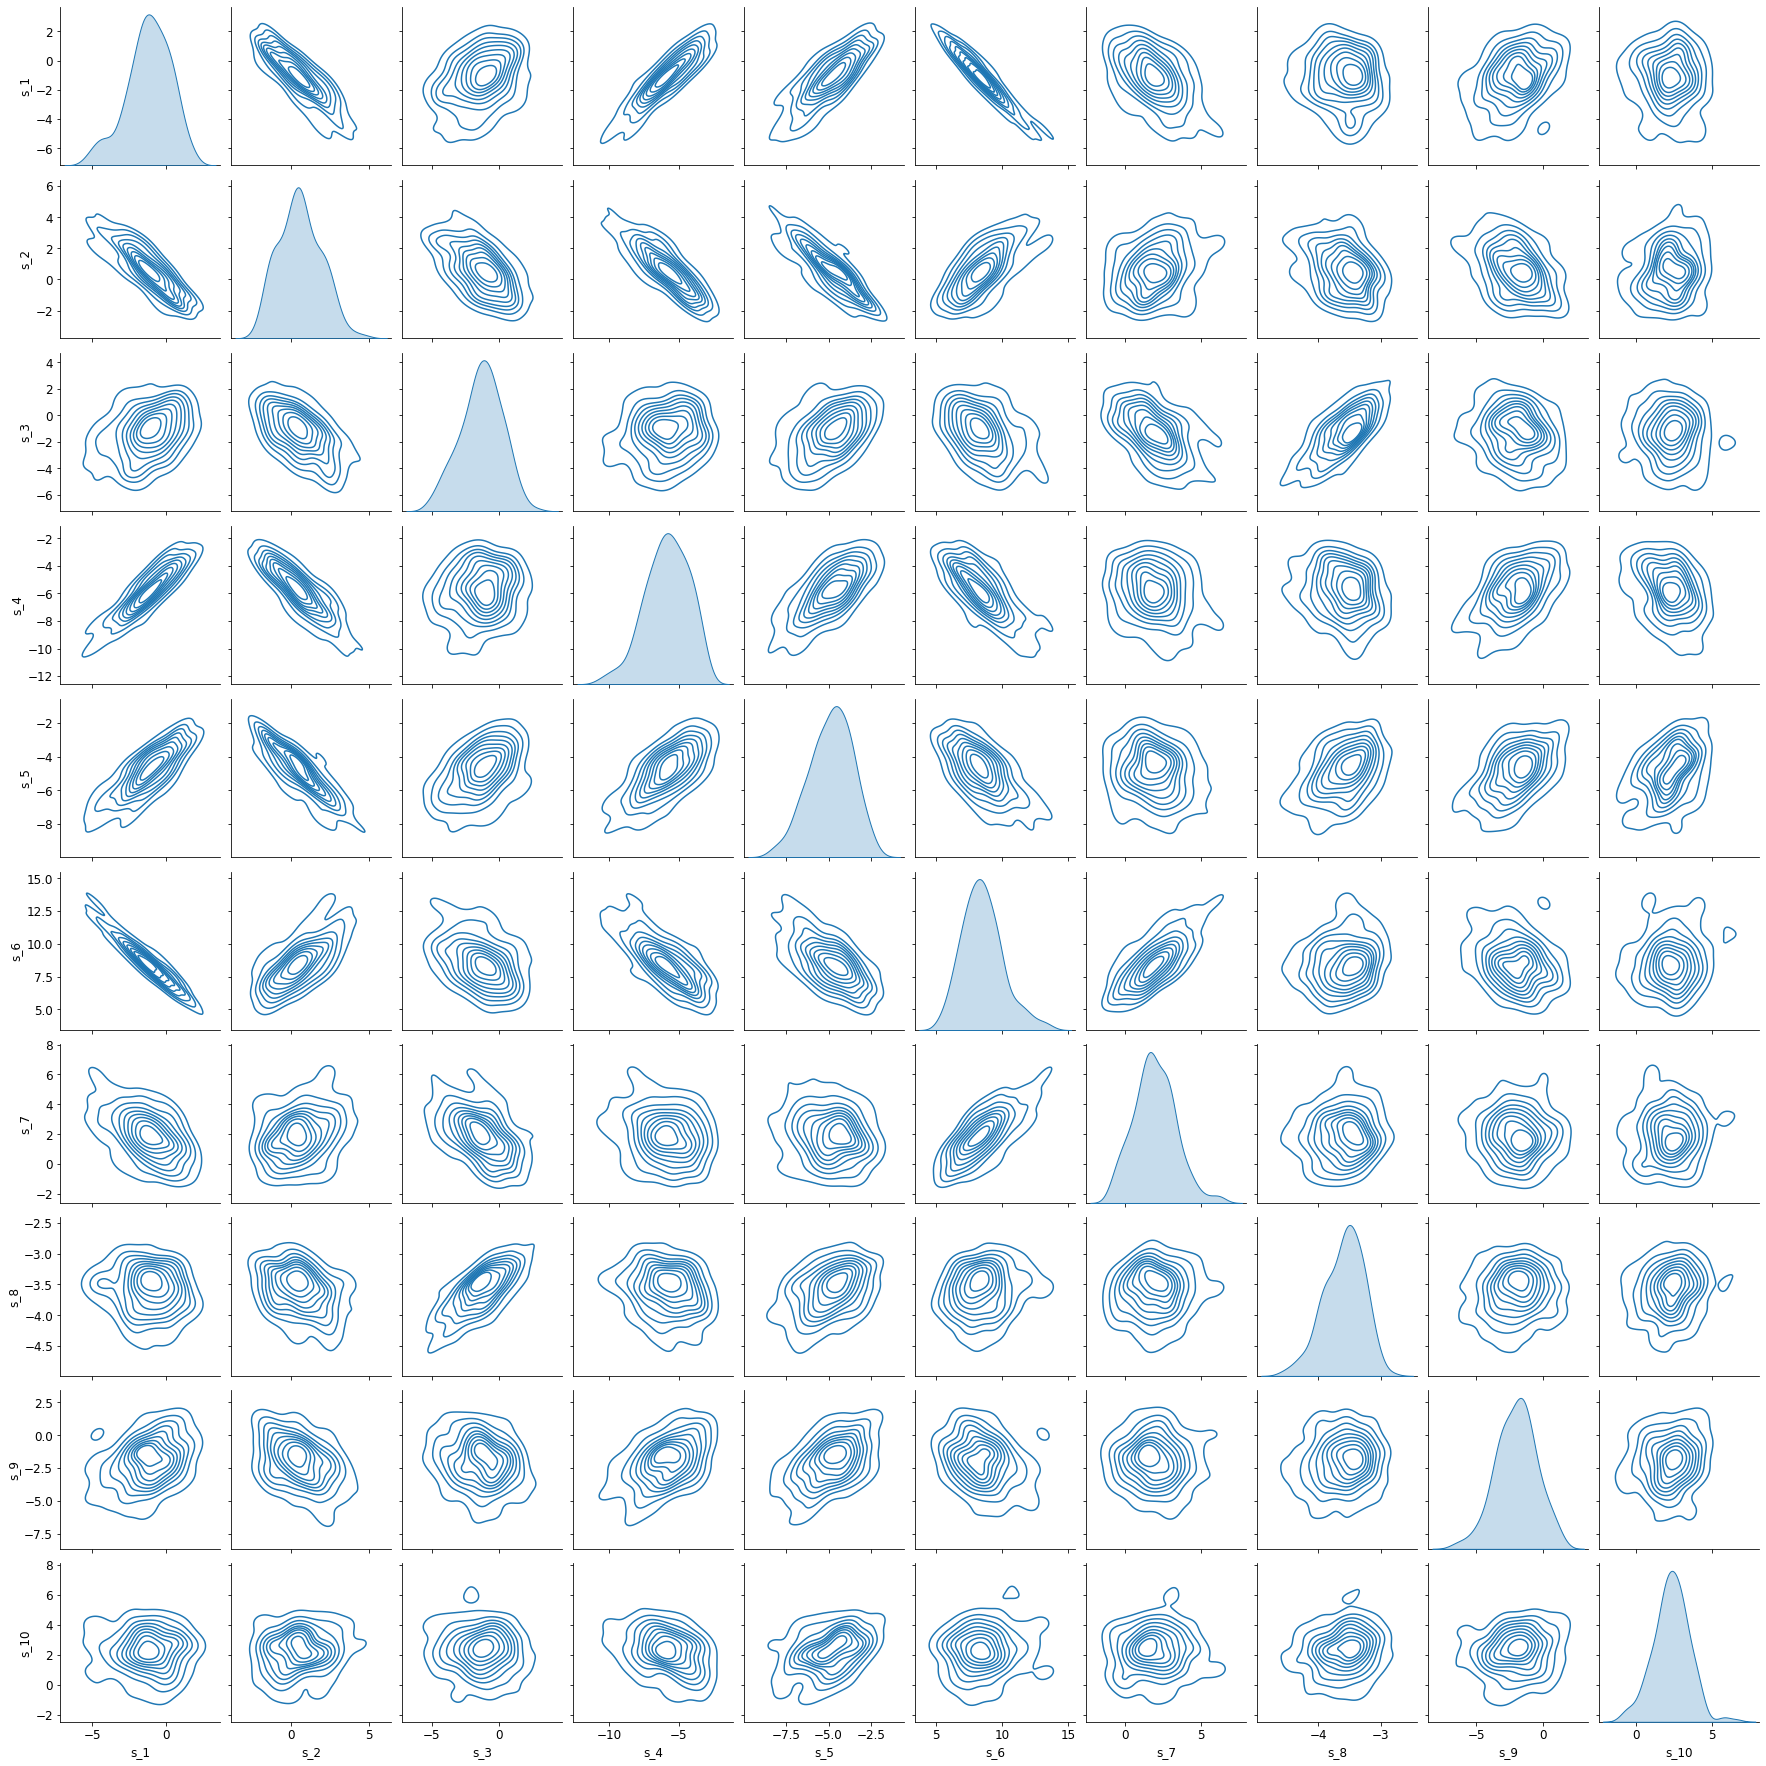

In [16]:
s = np.array(trainer.network.summary_net(x))
sns.pairplot(pd.DataFrame(s, columns=['s_{}'.format(i) for i in range(1, s.shape[1]+1)]), kind="kde")

# (3) Adversarial Tasks

In [4]:
# Hypersetup for all tasks
D = 5

In [63]:
def calculate_analytic_posterior(prior, simulator, x):
    n_sim, n_obs, D = x.shape
    
    # Set up variables
    x_bar = np.mean(x, axis=1)                 # empirical mean
    sigma_0 = np.eye(D) * prior.mu_scale       # mu prior covariance
    sigma_0_inv = np.linalg.inv(sigma_0)       # inverse mu prior covariance
    mu_0 = np.ones((D, 1)) * prior.mu_mean     # mu prior mean
    sigma = simulator.sigma                    # likelihood covariance
    sigma_inv = np.linalg.inv(sigma)           # inverse likelihood covariance
    
    mu_posterior_covariance = np.stack([np.linalg.inv(sigma_0_inv + n_obs*sigma_inv)] * n_sim)
    
    mu_posterior_mean = mu_posterior_covariance @ (sigma_0_inv @ mu_0 + n_obs * (sigma_inv @ x_bar[..., np.newaxis]))   
    mu_posterior_mean = mu_posterior_mean.reshape(n_sim, D)

    return mu_posterior_mean, mu_posterior_covariance

In [141]:
def adversarial_diagnostics(trainer, generative_model, theta=None, x=None, print_pairplot_summarynet=False, print_pairplot_posteriors=False):
    theta, x = generative_model(200, 100) if theta is None and x is None else (theta, x)
    param_samples = trainer.network.sample(x, n_samples=200)
    param_means = param_samples.mean(axis=0)
    
    # true parameters
    print("BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas")
    true_vs_estimated(theta, param_means, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))
    
    # analytic posteriors
    print("\n\nBayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means")
    prior = trainer.generative_model.prior.__self__
    simulator = trainer.generative_model.simulator
    posterior_means, posterior_covariances = calculate_analytic_posterior(prior, simulator, x)
    posterior_variances = posterior_covariances.diagonal(axis1=1, axis2=2)
    true_vs_estimated(posterior_means, param_means, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))
    
    
    print("\n\nAnalytic posterior means (x) vs. true thetas (y)")
    true_vs_estimated(posterior_means, theta, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))

    if print_pairplot_summarynet:
        print('\n\nSummary network response for one batch')
        s = np.array(trainer.network.summary_net(x))
        sns.pairplot(pd.DataFrame(s, columns=['s_{}'.format(i) for i in range(1, s.shape[1]+1)]), kind="kde")
        
    if print_pairplot_posteriors:
        print('\n\nFull posterior for one dataset.')
        p = param_samples[0]
        sns.pairplot(pd.DataFrame(p, columns=['dim_{}'.format(i) for i in range(1, p.shape[1]+1)]), kind="kde")

## (A1) Wrong Prior
The prior over the multivariate Gaussian's means is Gaussian: $\mu\sim\mathcal{N}(\mu_\mu, \sigma_\mu)$

During training, the mean's prior was $\mu\sim\mathcal{N}(0, 1)$. This adversarial tasks varies the prior in three steps for the evaluation:

- **(A1)-1** Wrong (free) prior location: $\mu\sim\mathcal{N}(\mu_\mu, 1)$
- **(A1)-2** Wrong (free) prior scale: $\mu\sim\mathcal{N}(0, \sigma_\mu)$
- **(A1)-3** Wrong (free) prior location and scale: $\mu\sim\mathcal{N}(\mu_\mu, \sigma_\mu)$

### (A1)-1 Wrong prior location

BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas


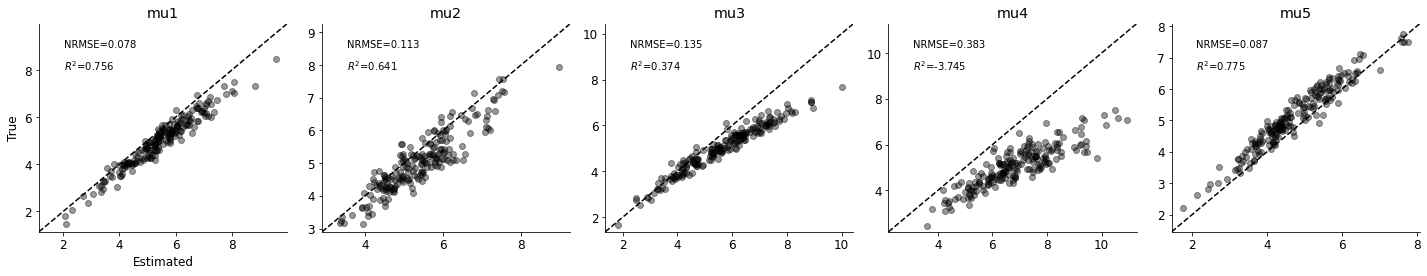



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


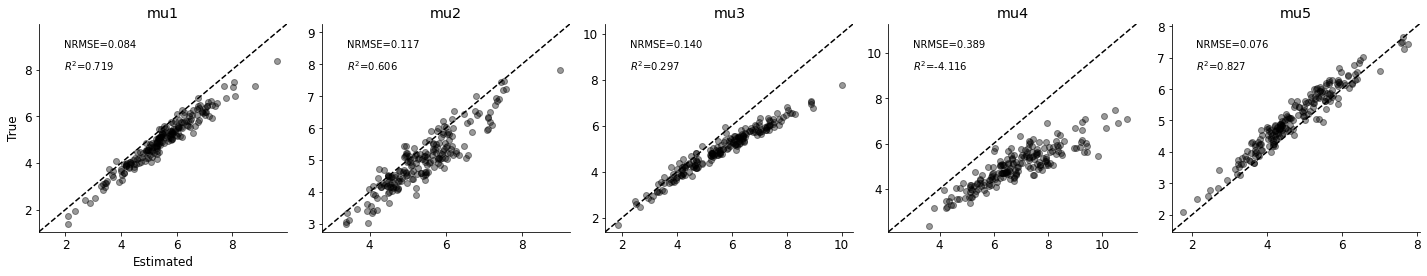



Analytic posterior means (x) vs. true thetas (y)


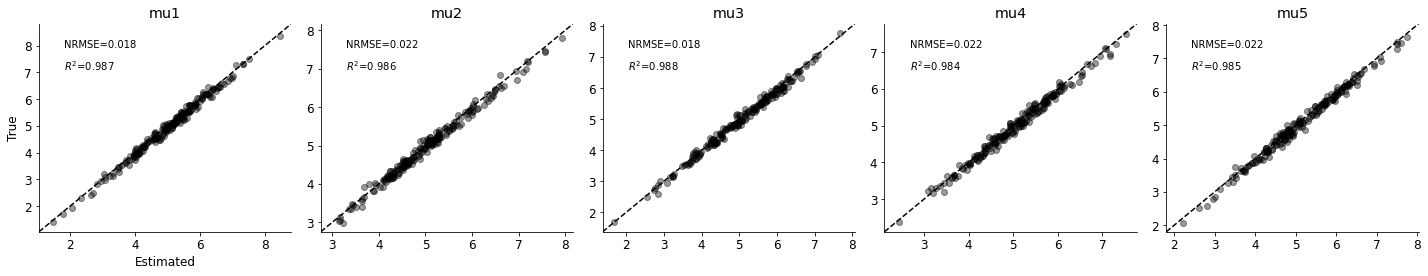

In [142]:
prior = GaussianPrior(D=D, mu_mean=5, mu_scale=1)
simulator = GaussianSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

adversarial_diagnostics(trainer, generative_model)

### (A1)-2 Wrong prior scale

BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas


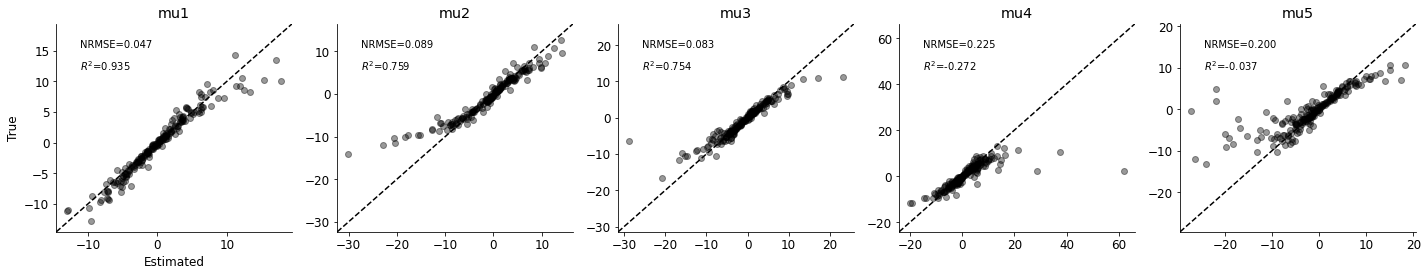



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


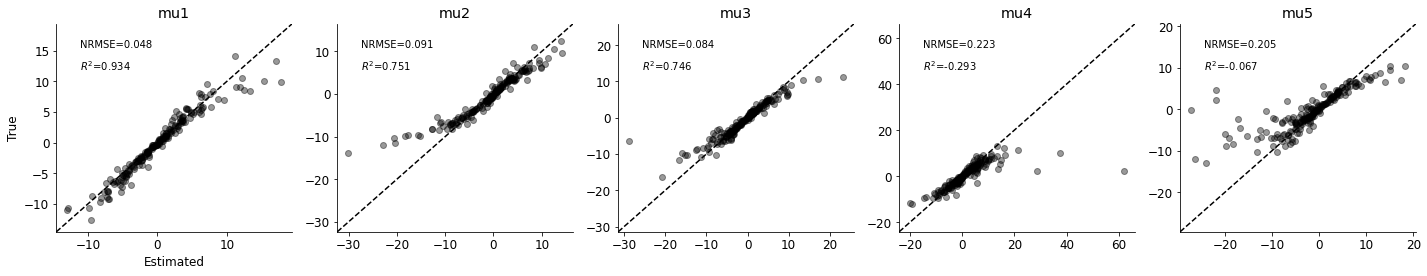



Analytic posterior means (x) vs. true thetas (y)


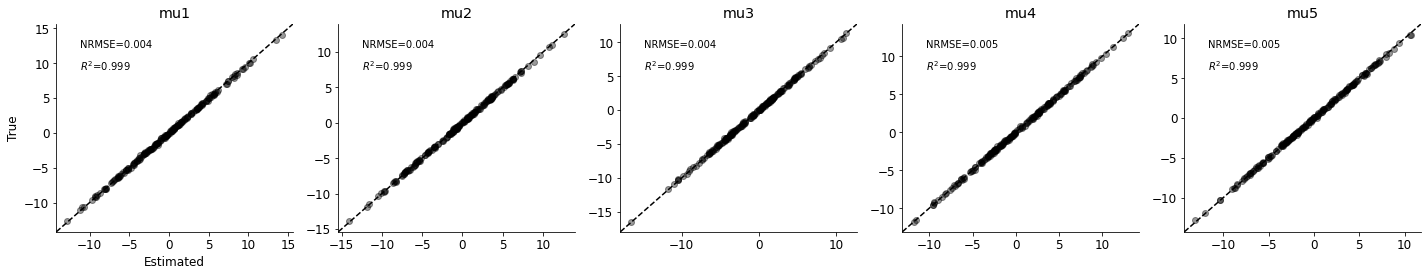

In [143]:
prior = GaussianPrior(D=D, mu_mean=0, mu_scale=5)
simulator = GaussianSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

adversarial_diagnostics(trainer, generative_model)

### (A1)-3 Wrong prior location and scale

BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas


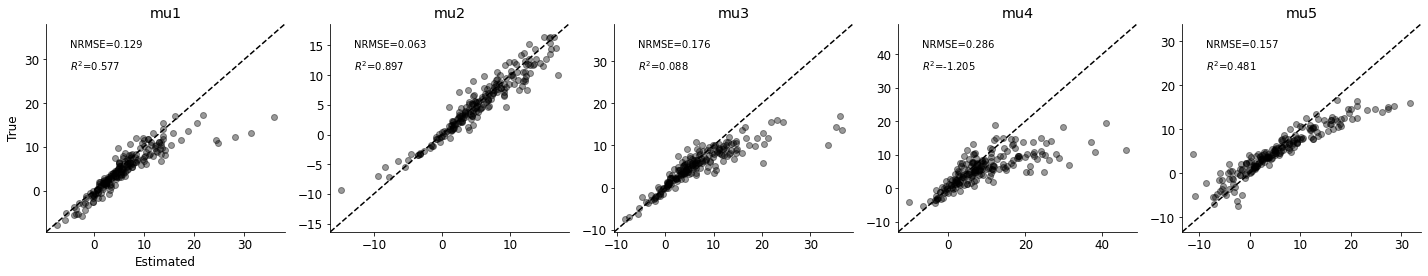



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


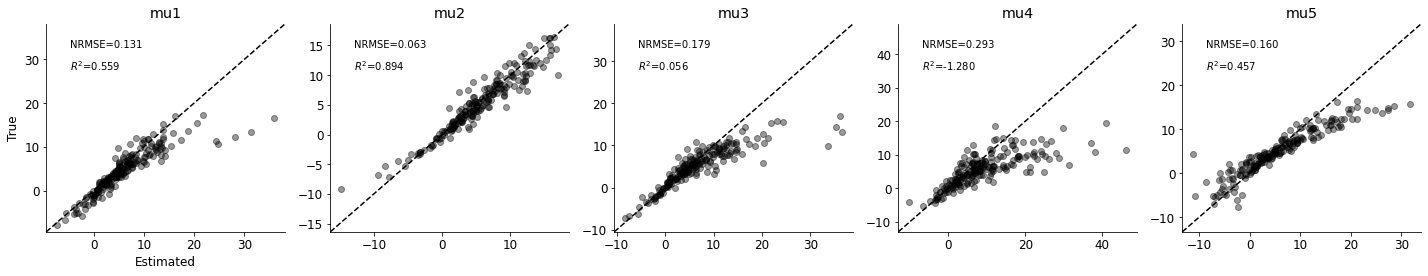



Analytic posterior means (x) vs. true thetas (y)


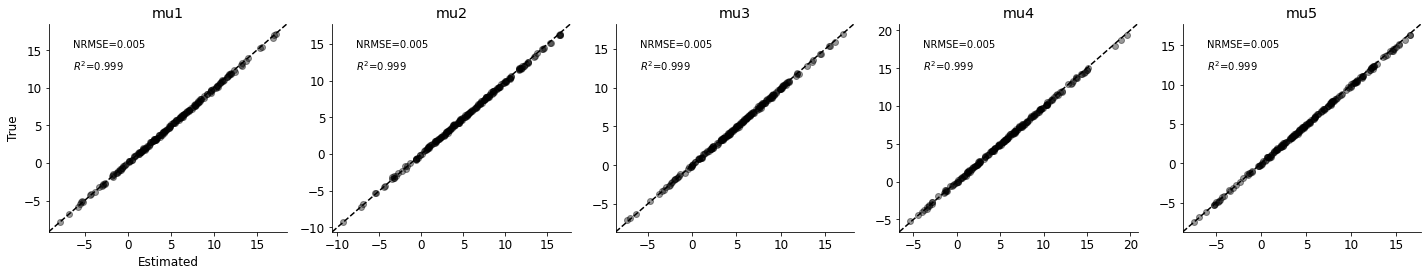

In [144]:
prior = GaussianPrior(D=D, mu_mean=5, mu_scale=5)
simulator = GaussianSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

adversarial_diagnostics(trainer, generative_model)

## (A2) Wrong parameterization of fixed parameters (correct Likelihood)

BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas


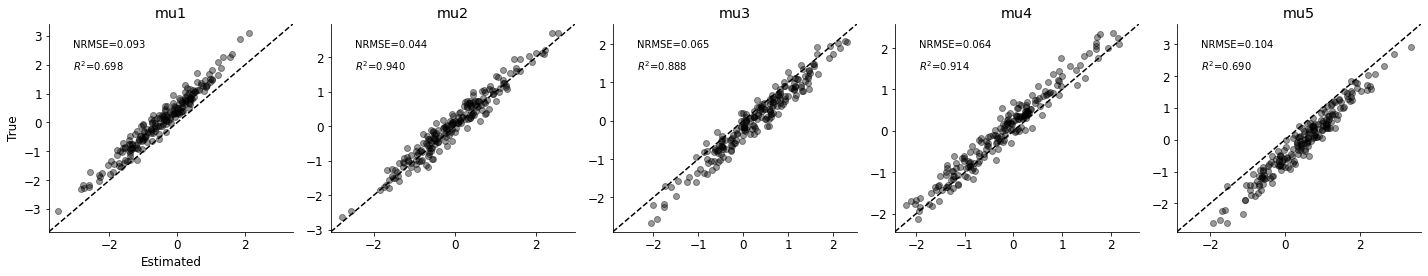



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


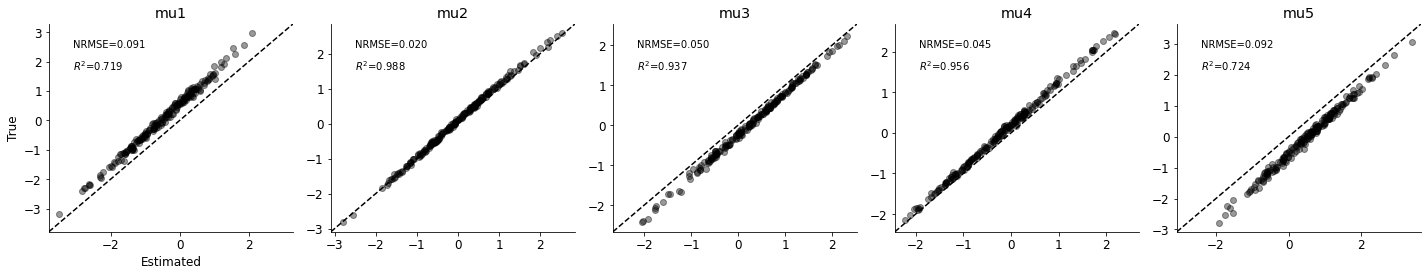



Analytic posterior means (x) vs. true thetas (y)


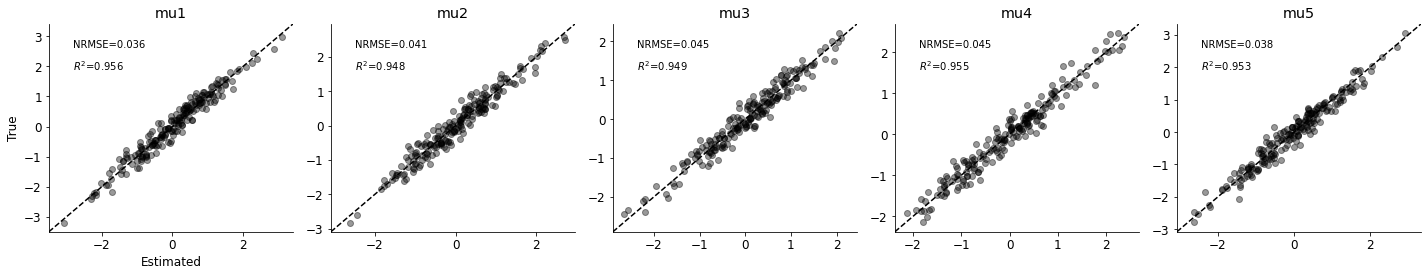

In [145]:
prior = GaussianPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianSimulator(D=D, s = 5.0)
generative_model = GenerativeModel(prior, simulator)

adversarial_diagnostics(trainer, generative_model)

BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas


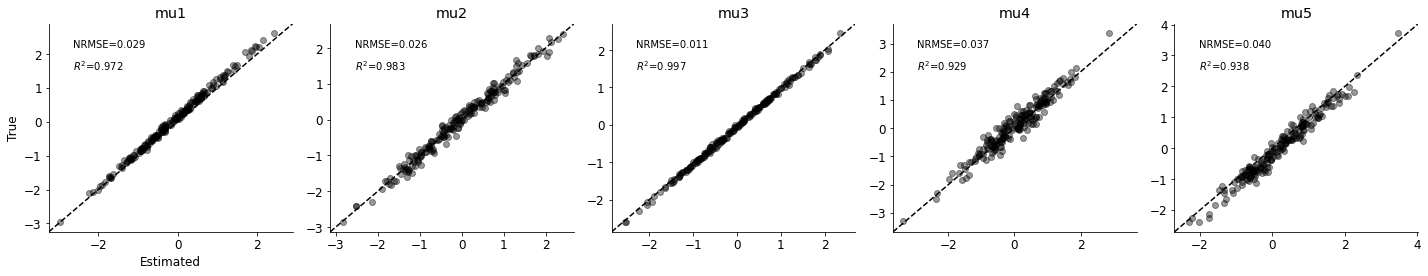



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


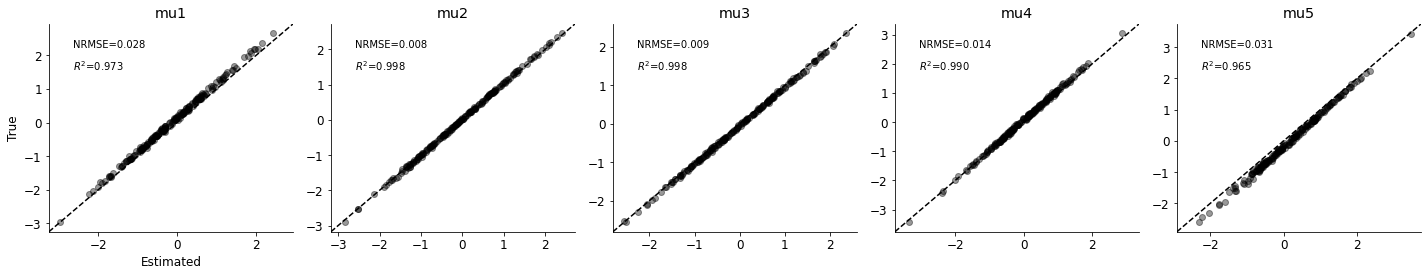



Analytic posterior means (x) vs. true thetas (y)


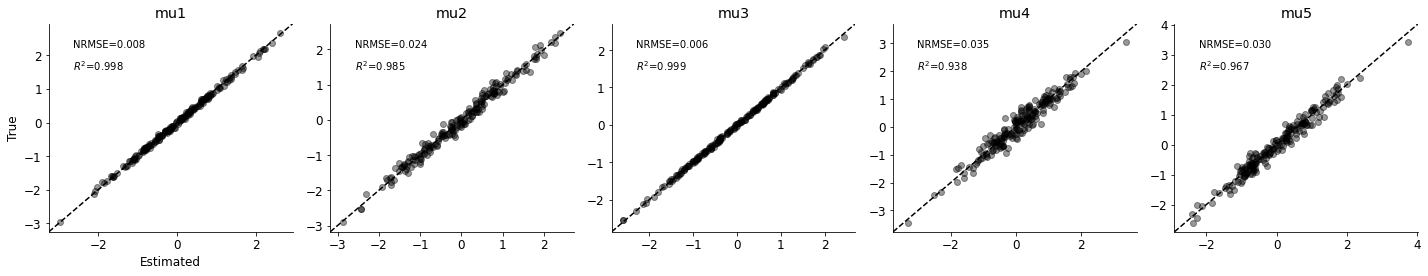

In [146]:
prior = GaussianPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianSimulator(D=D, s = [0.2, 2, 0.1, 5, 3])
generative_model = GenerativeModel(prior, simulator)

adversarial_diagnostics(trainer, generative_model)

## (A3) Wrong Likelihood

BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas


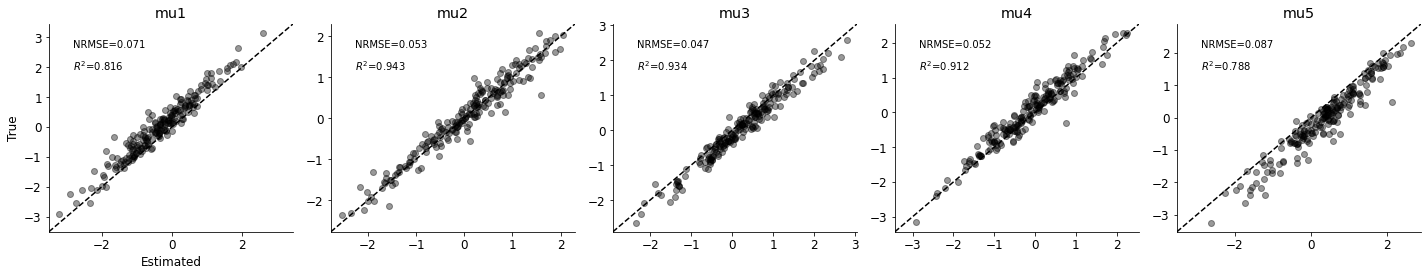



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


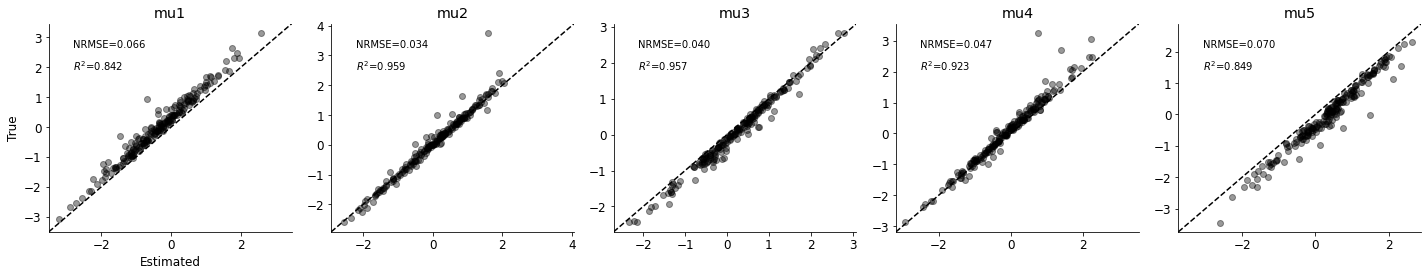



Analytic posterior means (x) vs. true thetas (y)


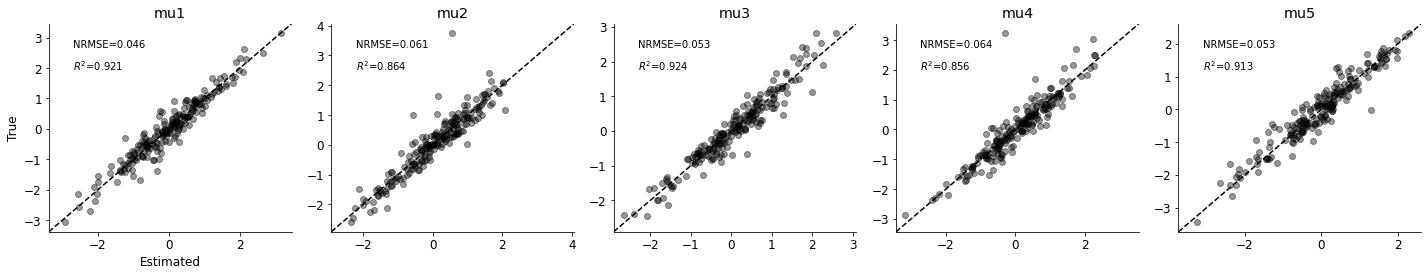

In [147]:
prior = GaussianPrior(D=D, mu_mean=0, mu_scale=1)
simulator = MultivariateTSimulator(df=2)

means = prior(200)
sigma = np.ones_like(means)
theta = np.concatenate((means, sigma), axis=1)
x = simulator(theta, 100)


adversarial_diagnostics(trainer, generative_model=None, theta=theta, x=x)

## (A4) Contamination
$\mathbf{x}_n = \mathbf{x}_n + \xi$

In [148]:
def normalize(x):
    n_sim, n_obs, data_dim = x.shape
    s = np.std(x, axis=1)
    s_reshaped = s.reshape(n_sim, 1, data_dim).repeat(n_obs, axis=1)
    x_normalized = np.divide(x, s_reshaped)
    return x_normalized

### Pink noise

In this scenario, the contamination $\xi$ is *pink noise* (aka $\frac{1}{f}$ noise) and added to the data $x$. The contaminated data is then normalized to obtain unit variance again.

$\tilde{x}=\dfrac{x+\xi}{\sigma_{x+\xi}}$ with $\xi \sim \frac{1}{f}$

BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas


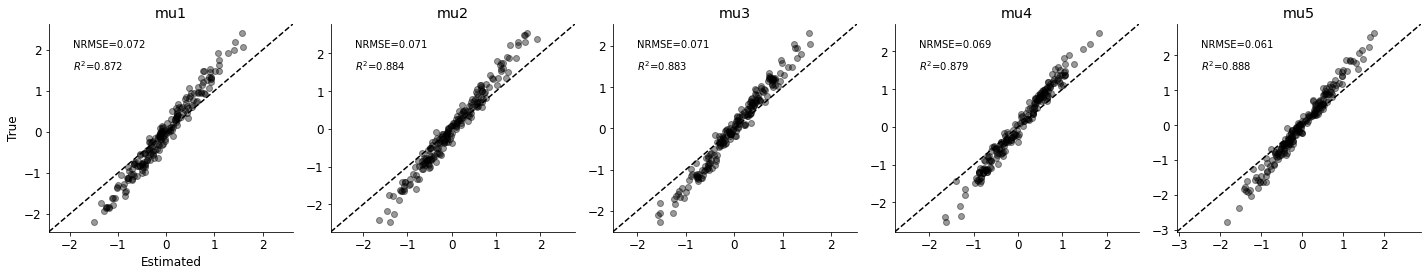



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


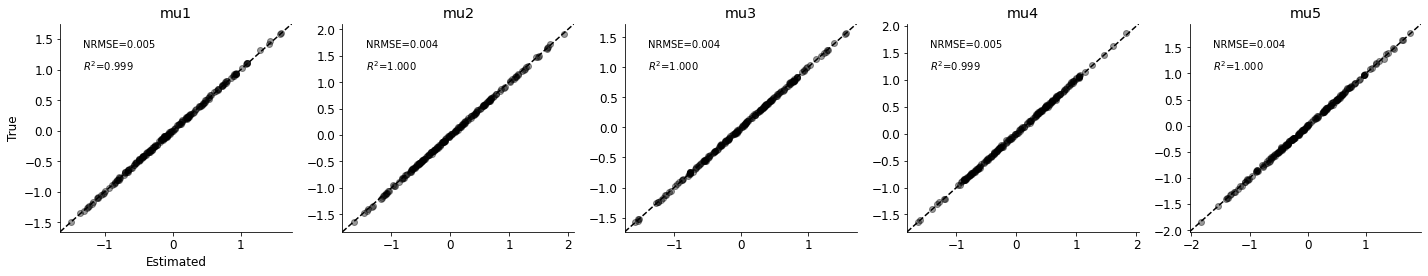



Analytic posterior means (x) vs. true thetas (y)


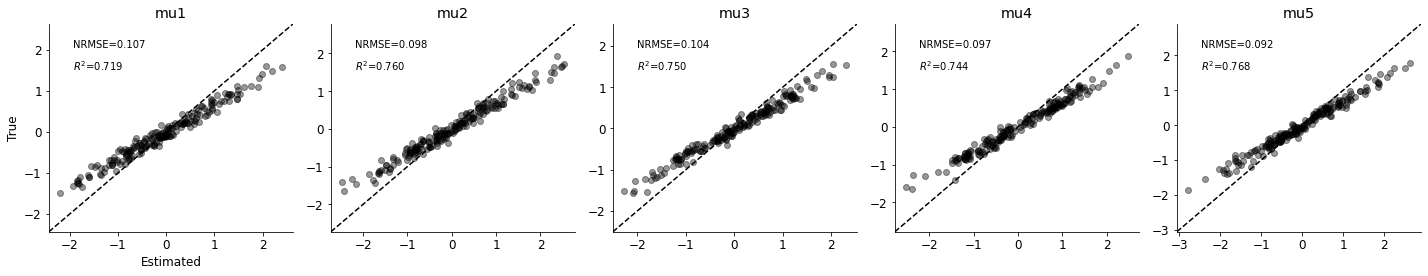

In [149]:
import colorednoise as cn

prior = GaussianPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianSimulator(D=D)

generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200, 100)

lamda = 1.0  # contribution of contamination xi 

xi = cn.powerlaw_psd_gaussian(exponent=1, size=x.shape)

x_tilde = normalize(x + lamda * xi)

adversarial_diagnostics(trainer, generative_model=None, theta=theta, x=x_tilde)

### t Noise
In this scenario, the contamination $\xi$ is $t-$distributed and added to the data $x$. The contaminated data is then normalized to obtain unit variance again.

$\tilde{x}=\dfrac{x+\xi}{\sigma_{x+\xi}}$ with $\xi \sim t(2)$

BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas


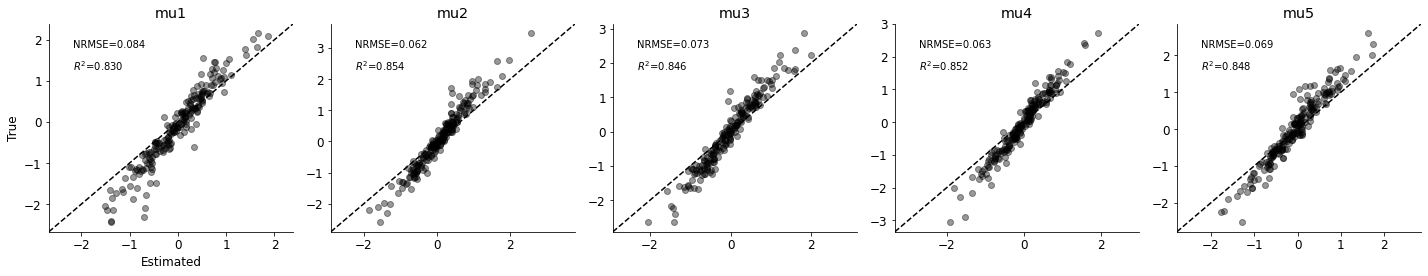



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


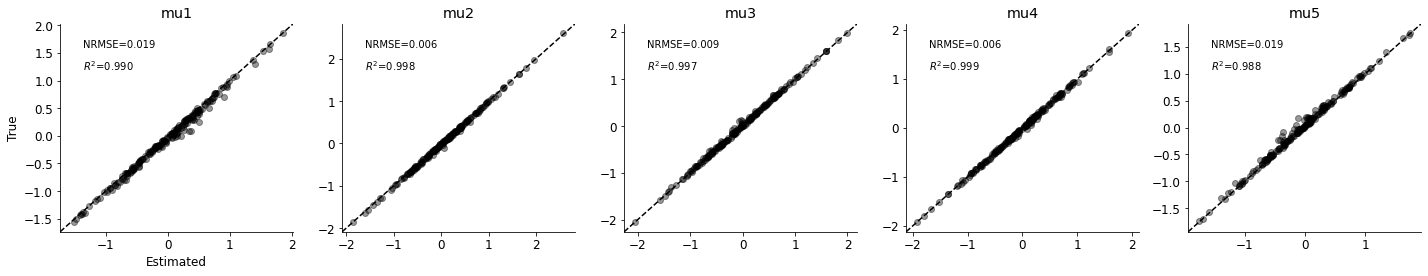



Analytic posterior means (x) vs. true thetas (y)


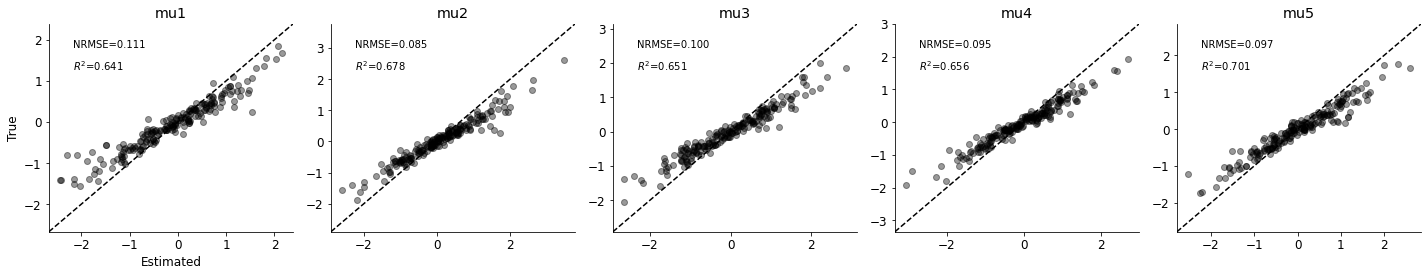



Full posterior for one dataset.


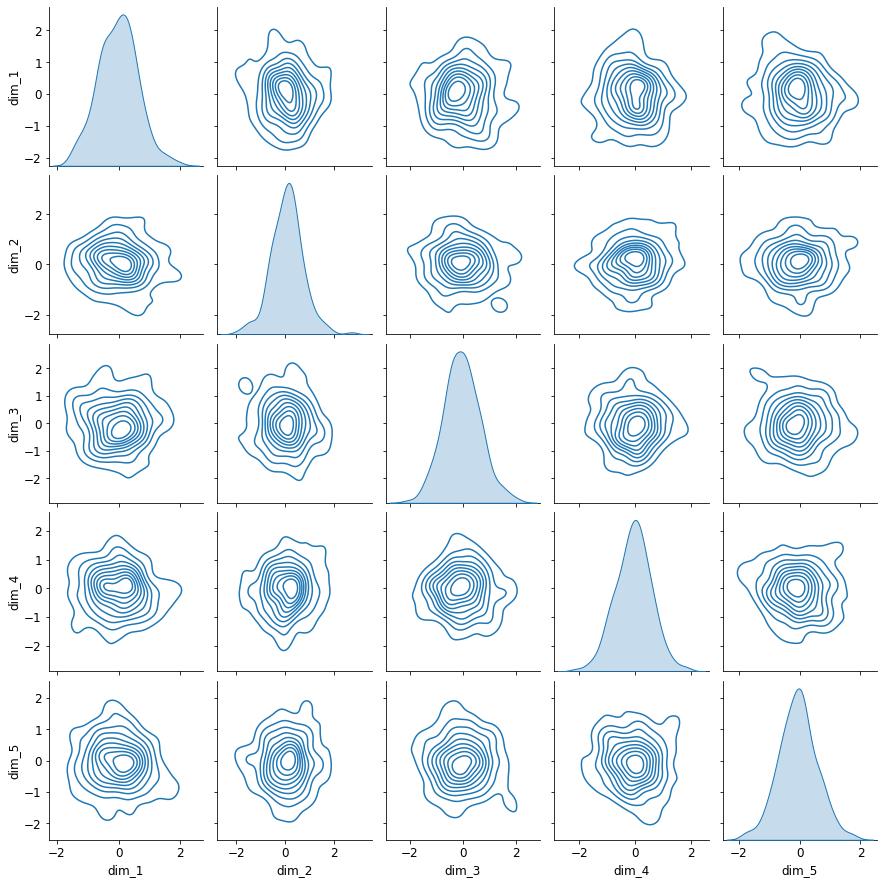

In [150]:
prior = GaussianPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

theta, x = generative_model(200, 100)

n_sim, n_obs, data_dim = x.shape


lamda = 0.5
xi_theta = np.concatenate((np.zeros((n_sim, data_dim)), np.ones((n_sim, data_dim))), axis=1)
xi_simulator = MultivariateTSimulator(df=2)
xi = xi_simulator(xi_theta, n_obs)

x_tilde = normalize(x + lamda * xi)

adversarial_diagnostics(trainer, generative_model=None, theta=theta, x=x_tilde, print_pairplot_posteriors=True)